Includes

In [31]:
using SparseArrays, LinearAlgebra, Arpack, Plots, LsqFit, RandomMatrix, TensorOperations

Auxilary functions

In [32]:
function random_ψ(L)
    ψ=rand(2^L)
    ψ./=norm(ψ)
    return ψ
end;

From Recitations

In [33]:
function NormalizePsi!(psi::Vector{Array{Float64}})
    """
    NormalizePsi!(psi::Vector{Array{Float64}})

    Normalize and bring the orthogonality center to the first site in a Matrix Product State (MPS), assuming right canonical form.

    # Arguments
    - `psi`: Array of matrices representing the MPS.

    """
    L = length(psi)

    # Iterate from the last site to the second site
    for i in L-1:-1:1
        # Calculate the bond tensor between current site i and i+1
        psi_bond = BondTensor(psi, i)

        # Orthogonally update the MPS using the Singular Value Decomposition (SVD), assuming right canonical form
        SvdBondTensor!(psi, i, psi_bond, false, -1, true)
        # ortho_left = false => Update the matrix at site i+1 (right canonical form)
        # maxM = -1 => No truncation
        # renorm = true => Renormalize the singular values
    end
end;

In [34]:
function SvN(psi, l)
    # Von Neumann entropy calculation to subsystems of size l and L-l From Recitation
    D = size(psi)[1]
    logD = log2(D)
    @assert isinteger(logD) "State vector of incompatible length"
    L = Int(logD) # How many qubits in the state?
    @assert l>0 && l<L "Invalid bipartition", L
    
    dims_tuple=(2^l,2^(L-l))
    print(dims_tuple)
    psi_matrix = reshape(psi, dims_tuple)
    U,s,V = svd(psi_matrix)
    s = s[s .> 1e-14] # choosing non-zero singular values
    w = s.^2
    return -sum(w.*log.(w))
end;

In [35]:
function PolarizedMPS(L::Int64)
    # Initialize an array to store matrices representing the polarized state MPS.
    psi = Array{Float64}[]

    # Iterate through each site in the 1D quantum system.
    for i in 1:L
        # For each site, add a matrix with coefficients [1.0, 0.0] to the array.
        push!(psi, reshape([1.0, 0.0], (1, 2, 1)))
    end

    # Return the array representing the polarized state MPS.
    return psi
end

function NeelMPS(L::Int64)
    # Initialize an array to store matrices representing the Neel state MPS.
    psi = Array{Float64}[]

    # Iterate through each site in the 1D quantum system.
    for i in 1:L
        # Check if the site index is odd (spin-up) or even (spin-down).
        if isodd(i)
            # For spin-up, add a matrix with coefficients [1.0, 0.0] to the array.
            push!(psi, reshape([1.0, 0.0], (1, 2, 1)))
        else
            # For spin-down, add a matrix with coefficients [0.0, 1.0] to the array.
            push!(psi, reshape([0.0, 1.0], (1, 2, 1)))
        end
    end

    # Return the array representing the Neel state MPS.
    return psi
end;

In [36]:
function MPSrep_LC(psi::Vector{Float64}, maxM=0)
    """
    MPSrep_LC(psi::Vector{Float64}, maxM=0)

    Convert a state vector into a Matrix Product State (MPS) representation using singular value decomposition (SVD).

    # Arguments
    - `psi`: The state vector to be converted into MPS.
    - `maxM`: The maximum number of singular values to keep in each step. If 0, no truncation is performed.

    # Returns
    - `psi_mps`: Array of matrices representing the MPS.
    - `VN`: Array of von Neumann entropies at each step.
    - `Ms`: Array of the number of retained singular values at each step.
    - `Trunc`: Array of truncation errors at each step if maxM > 0 and truncation occurs.

    """
    D = size(psi)[1]
    logD = log2(D)
    @assert isinteger(logD) "State vector of incompatible length"
    L = Int(logD) # How many qubits in the state?
    psi_mps = []
    VN = []
    Ms = []
    Trunc = []

    psi_matrix = reshape(psi, (2, 2^(L-1)))

    for l in 1:L-1
        # Singular Value Decomposition (SVD)
        U, s, V = svd(psi_matrix)

        # Find the last non-zero singular value
        Ml = findlast(s .> 1e-14)

        # Retain only relevant parts of U, s, and V
        U, s, V = U[:, 1:Ml], s[1:Ml], V[:, 1:Ml]

        # Calculate von Neumann entropy
        w = s.^2
        svn = -sum(w .* log.(w))

        # If 0 < maxM < Ml - truncation, perform truncation
        if (maxM > 0 && Ml > maxM)
            trunc = sum(s[maxM:end].^2)
            push!(Trunc, trunc)
            U, s, V = U[:, 1:maxM], s[1:maxM], V[:, 1:maxM]
            s /= sqrt(1. - trunc)
            Ml = maxM
        end

        push!(Ms, Ml)
        push!(VN, svn)

        # Reshape U into the MPS format
        if (l == 1)
            push!(psi_mps, reshape(U, (1, 2, Ml)))
        else
            push!(psi_mps, reshape(U, (Ms[end-1], 2, Ml)))
        end

        # Reshape V into the MPS format for the next iteration
        if (l == L-1)
            push!(psi_mps, reshape(diagm(s) * V', (Ml, 2, 1)))
        else
            psi_matrix = reshape(diagm(s) * V', (2 * Ml, 2^(L-l-1)))
        end
    end

    return psi_mps, VN, Ms, Trunc
end;

In [37]:
function BondTensor(psi::Vector{Array{Float64}}, b::Int64)
    """
    BondTensor(psi::Vector{Array{Float64}}, b::Int64)

    Construct the bond tensor between two adjacent sites in a Matrix Product State (MPS).

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).

    # Returns
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.

    """
    @assert b >= 1 && b <= (length(psi)-1) "Bond out of range"

    # Dimensions of matrices at site b and site b+1
    M0 = size(psi[b])[1]
    M2 = size(psi[b+1])[3]

    # Initialize the bond tensor
    psi_bond = zeros(M0, 2, 2, M2)

    # Contract matrices at site b and site b+1 to form the bond tensor
    @tensor psi_bond[l0, s1, s2, l2] = psi[b][l0, s1, l1] * psi[b+1][l1, s2, l2]

    return psi_bond
end;

In [38]:
function SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)
    """
    SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)

    Update the Matrix Product State (MPS) by performing a Singular Value Decomposition (SVD) on the bond tensor.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.
    - `ortho_left`: If true, orthogonally update the matrix at site `b` (left-canonical). If false, orthogonally update the matrix at site `b+1` (right-canonical).
    - `maxM`: The maximum number of singular values to keep in each step. If -1, no truncation is performed.
    - `renorm`: If true, renormalize the singular values after the SVD.

    # Returns
    - `trunc`: Truncation error if truncation occurs, otherwise 0.

    """
    @assert length(size(psi_bond)) == 4 "psi_bond is expected to be a rank-4 tensor"

    trunc = 0.

    M0 = size(psi_bond)[1]
    M2 = size(psi_bond)[4]

    # Reshape the bond tensor into a matrix for SVD
    psi_bond_matrix = reshape(psi_bond, (M0*2, M2*2))

    # Perform SVD on the reshaped bond tensor matrix
    U, S, V = svd(psi_bond_matrix)

    # Optionally renormalize the singular values
    if renorm
        S /= norm(S)
    end

    # Find the last non-zero singular value
    M1 = findlast(S .> 1e-16)

    # Retain only relevant parts of U, S, and V
    U, S, V = U[:, 1:M1], S[1:M1], V[:, 1:M1]

    # If 0 < maxM < M1 - truncation, perform truncation
    if maxM > 0 && M1 > maxM
        trunc = sum(S[maxM:end].^2)
        U, S, V = U[:, 1:maxM], S[1:maxM], V[:, 1:maxM]
        S /= sqrt(1. - trunc)
        M1 = maxM
    end

    # Update the MPS matrices based on the SVD results
    if ortho_left
        psi[b] = reshape(U, (M0, 2, M1))
        psi[b+1] = reshape(Diagonal(S) * V', (M1, 2, M2))
    else
        psi[b] = reshape(U * Diagonal(S), (M0, 2, M1))
        psi[b+1] = reshape(V', (M1, 2, M2))
    end

    return trunc
end;

In [39]:
function BondH(h1::Float64, h2::Float64)
    """
    BondH(h1::Float64, h2::Float64)

    Generate the bond Hamiltonian matrix for a two-site bond in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The Hamiltonian matrix for the two-site bond in the TFIM.

    """
    # Pauli matrices
    Sx = [0.0 1.0; 1.0 0.0]
    Sz = [1.0 0.0; 0.0 -1.0]
    Id = [1.0 0.0; 0.0 1.0]

    # Construct the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = -kron(Sz, Sz) + h1 * kron(Sx, Id) + h2 * kron(Id, Sx)
    
    return Hb
end;

In [40]:
function GateTensor(dt::Float64, h1::Float64, h2::Float64)
    """
    GateTensor(dt::Float64, h1::Float64, h2::Float64)

    Generate the gate tensor for a time evolution step in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `dt`: Time step for the evolution.
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The gate tensor for the time evolution step in the TFIM.

    """
    # Generate the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = BondH(h1, h2)

    # Construct the gate tensor for the time evolution step using the Hamiltonian
    G = exp(-dt/2 * Hb)

    # Reshape the gate tensor to a 4-index tensor
    return reshape(G, (2, 2, 2, 2))
end;

In [41]:
function ApplyGate!(psi::Vector{Array{Float64}}, op::Array{Float64}, b::Int64, ortho_left=true, maxM=-1, renorm=false)
    """
    ApplyGate!(psi::Vector{Array{Float64}}, op::Array{Float64}, b::Int64, ortho_left=true, maxM=-1, renorm=false)

    Apply a gate to a specific bond in the Matrix Product State (MPS) representation.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `op`: Array representing the gate to be applied.
    - `b`: Index of the bond where the gate is applied.
    - `ortho_left`: If true, update the left canonical form after applying the gate. Default is true.
    - `maxM`: Maximum bond dimension. If -1, no truncation is performed. Default is -1.
    - `renorm`: If true, renormalize singular values after applying the gate. Default is false.

    # Returns
    The truncation error if truncation is performed.

    """
    trunc = 0.

    # Calculate the bond tensor for the current bond
    psi_bond = BondTensor(psi, b)

    # Initialize a new bond tensor after applying the gate
    new_psi_bond = zeros(size(psi_bond))
    
    # Contract the gate with the current bond tensor to obtain the new bond tensor
    @tensor new_psi_bond[l0, s1p, s2p, l2] = op[s2p, s1p, s2, s1] * psi_bond[l0, s1, s2, l2]

    # Update the MPS by applying the new bond tensor
    trunc = SvdBondTensor!(psi, b, new_psi_bond, ortho_left, maxM, renorm)

    return trunc
end;

In [42]:
function iTEBD_sweep!(psi::Vector{Array{Float64}}, dt::Float64, h::Float64, maxM::Int64)
    """
    iTEBD_sweep!(psi::Vector{Array{Float64}}, dt::Float64, h::Float64, maxM::Int64)

    Perform a single sweep of the imaginary time evolution using Time-Evolving Block Decimation (iTEBD).

    # Arguments
    - `psi`: Array of matrices representing the Matrix Product State (MPS).
    - `dt`: Time step for the evolution.
    - `h`: Transverse field strength.
    - `maxM`: Maximum bond dimension.

    # Returns
    The maximum truncation error during the sweep.

    """
    L = length(psi)
    
    maxTrunc = 0.

    # Sweep right
    for i in range(1, stop=L-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        gateOp = GateTensor(dt, h1, h2)
        
        # Apply the gate, update orthogonality center to the right, and renormalize
        trunc = ApplyGate!(psi, gateOp, i, true, maxM, true)
        
        # Update the maximum truncation error
        if trunc > maxTrunc
            maxTrunc = trunc
        end
    end
    
    # Sweep left
    for i in range(L-1, stop=1, step=-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        gateOp = GateTensor(dt, h1, h2)
        
        # Apply the gate, update orthogonality center to the left, and renormalize
        trunc = ApplyGate!(psi, gateOp, i, false, maxM, true)
        
        # Update the maximum truncation error
        if trunc > maxTrunc
            maxTrunc = trunc
        end
    end
    
    return maxTrunc
end;

In [43]:
function CalculateEnergy!(psi::Vector{Array{Float64}}, h::Float64)
    """
    CalculateEnergy!(psi::Vector{Array{Float64}}, h::Float64)

    Calculate the energy of the Matrix Product State (MPS) representation.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `h`: Transverse field strength.

    # Returns
    The total energy of the MPS.

    """
    L = length(psi)
    
    Etot = 0.

    for i in range(1, stop=L-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        
        # Generate the Hamiltonian matrix for the two-site bond
        Hb = reshape(BondH(h1, h2), (2, 2, 2, 2))
        
        # Calculate the bond tensor for the current bond
        psi_bond = BondTensor(psi, i)
        
        # Initialize a tensor for H * psi
        H_psi = zeros(size(psi_bond))
        
        # Contract H with the current bond tensor to obtain H * psi
        @tensor H_psi[l0, s1p, s2p, l2] = Hb[s2p, s1p, s2, s1] * psi_bond[l0, s1, s2, l2]
        
        # Contract psi^† * H * psi to obtain the energy contribution
        @tensor psi_H_psi = psi_bond[l0, s1p, s2p, l2] * H_psi[l0, s1p, s2p, l2]
        
        # Accumulate the energy contribution
        Etot += psi_H_psi
        
        # Update the MPS by applying the new bond tensor with left canonical form (no truncation or renormalization)
        SvdBondTensor!(psi, i, psi_bond, true)
    end
    
    return Etot
end;

In [44]:
mutable struct MPSrep
    oc::Int64                        # orthogonality center
    maxM::Int64                      # maximal bond dimension
    state::Vector{Array{Float64}}  
    
    function MPSrep(psi::Vector{Float64}, maxM=-1)
        # initial MPS given in left-canonical form, oc at rightmost site
        state, VN, Ms, Trunc = MPSrep_LC(psi, maxM)
        oc = length(state)
        new(oc, maxM, state)
    end
    
    function MPSrep(psi::Vector{Array{Float64}})
        # initial MPS given in right-canonical form, oc at leftmost site
        oc = 1
        maxM = -1
        state = deepcopy(psi)
        new(oc, maxM, state)
    end
    
end;

In [45]:
function CorrelationsByLength(psi_mps::MPSrep, Op)
    """
    CorrelationsByLength(psi_mps::MPSrep, Op)

    Calculate correlations by length for an operator (Op) in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the correlations.

    # Returns
    An array of correlation values for each site.

    """
    i0 = 1
    Corr = []

    # Move the orthogonality center to the first site
    OrthogonalizePsi!(psi_mps, i0)
    Ai0 = psi_mps.state[i0]
    M0 = size(Ai0)[1]
    M1 = size(Ai0)[3]

    # Initialize tensors for Ai * Op
    Ai_Sop = zeros(M0, 2, M1)
    @tensor Ai_Sop[l0, sp, l1] = Ai0[l0, s, l1] * Op[s, sp]

    # Calculate Ai * Op * Ai'
    AiAip = zeros(M1, M1)
    @tensor AiAip[l1, l1p] = Ai_Sop[l0, sp, l1] * Ai0[l0, sp, l1p]

    for j0 in 2:L
        # Iterate from i0+1 to j0-1
        for k in i0+1:j0-1
            Ak = psi_mps.state[k]
            M2 = size(Ak)[3]

            # Initialize tensors for AiAip * Ak
            AiAip_Ak = zeros(M1, 2, M2)
            @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Ak[l1, s, l2]

            # Calculate AiAip * Ak * AiAip'
            AiAip = zeros(M2, M2)
            @tensor AiAip[l2, l2p] = AiAip_Ak[l1p, s, l2] * Ak[l1p, s, l2p]

            # Update M1 for the next iteration
            M1 = M2
        end

        Aj0 = psi_mps.state[j0]
        M2 = size(Aj0)[3]

        # Initialize tensors for AiAip * Ak * Op
        AiAip_Ak = zeros(M1, 2, M2)
        @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Aj0[l1, s, l2]
        AiAip_Ak_Op = zeros(M1, 2, M2)
        @tensor AiAip_Ak_Op[l1p, sp, l2] = AiAip_Ak[l1p, s, l2] * Op[s, sp]

        # Calculate AiAip * Ak * Op * Aj0'
        @tensor Val = AiAip_Ak_Op[l1p, sp, l2] * Aj0[l1p, sp, l2]

        # Store the correlation value
        push!(Corr, Val)
    end

    return Corr
end;

In [74]:
function OrthogonalizePsi!(psi_mps::MPSrep, i0::Int64)
    """
    OrthogonalizePsi!(psi_mps::MPSrep, i0::Int64)

    Bring the orthogonality center to site i0 in a Matrix Product State (MPS), updating the MPS representation.

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `i0`: The target site to which the orthogonality center (oc) should be moved.

    """
    L = length(psi_mps.state)
    oc = psi_mps.oc

    if i0 > oc
        # Move the orthogonality center to the right: Add more left canonical forms
        for i in oc:i0-1
            psi_bond = BondTensor(psi_mps.state, i)
            # ortho_left = true => Update the matrix at site i (left canonical form)
            # maxM = -1 => No truncation
            # renormalize = false => Do not renormalize the singular values
            SvdBondTensor!(psi_mps.state, i, psi_bond, true)
        end
    elseif i0 < oc
        # Move the orthogonality center to the left
        for i in oc-1:-1:i0
            psi_bond = BondTensor(psi_mps.state, i)
            # ortho_left = false => Update the matrix at site i+1 (right canonical form)
            # maxM = -1 => No truncation
            # renormalize = false => Do not renormalize the singular values
            SvdBondTensor!(psi_mps.state, i, psi_bond, false)
        end
    end

    # Update the orthogonality center
    psi_mps.oc = i0
end;

In [46]:
function ExpectationValue(psi_mps::MPSrep, Op)
    """
    ExpectationValue(psi_mps::MPSrep, Op)

    Calculate the expectation values of an operator (Op) for each site in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the expectation values.

    # Returns
    An array of expectation values for each site.

    """
    L = length(psi_mps.state)
    ExpVals = zeros(L)

    for i in 1:L
        # Orthogonalize the MPS up to site i
        OrthogonalizePsi!(psi_mps, i)

        # Extract the matrix Ai from the MPS representation at site i
        Ai = psi_mps.state[i]
        M0 = size(Ai)[1]
        M1 = size(Ai)[3]

        # Initialize the tensor representing Ai * Op
        Ai_Sop = zeros(M0, 2, M1)

        # Contract Ai with Op to obtain Ai_Sop tensor
        @tensor Ai_Sop[l0, sp, l1] = Ai[l0, s, l1] * Op[s, sp]

        # Calculate the expectation value
        @tensor Val = Ai_Sop[l0, sp, l1] * Ai[l0, sp, l1]
        ExpVals[i] = Val
    end

    return ExpVals
end;

In [127]:
function CorrelationsByLength(psi_mps::MPSrep, Op)
    """
    CorrelationsByLength(psi_mps::MPSrep, Op)

    Calculate correlations by length for an operator (Op) in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the correlations.

    # Returns
    An array of correlation values for each site.

    """
    i0 = 1
    Corr = []

    # Move the orthogonality center to the first site
    OrthogonalizePsi!(psi_mps, i0)
    Ai0 = psi_mps.state[i0]
    M0 = size(Ai0)[1]
    M1 = size(Ai0)[3]

    # Initialize tensors for Ai * Op
    Ai_Sop = zeros(M0, 2, M1)
    @tensor Ai_Sop[l0, sp, l1] = Ai0[l0, s, l1] * Op[s, sp]

    # Calculate Ai * Op * Ai'
    AiAip = zeros(M1, M1)
    @tensor AiAip[l1, l1p] = Ai_Sop[l0, sp, l1] * Ai0[l0, sp, l1p]

    for j0 in 2:L
        # Iterate from i0+1 to j0-1
        for k in i0+1:j0-1
            Ak = psi_mps.state[k]
            M2 = size(Ak)[3]

            # Initialize tensors for AiAip * Ak
            AiAip_Ak = zeros(M1, 2, M2)
            @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Ak[l1, s, l2]

            # Calculate AiAip * Ak * AiAip'
            AiAip = zeros(M2, M2)
            @tensor AiAip[l2, l2p] = AiAip_Ak[l1p, s, l2] * Ak[l1p, s, l2p]

            # Update M1 for the next iteration
            M1 = M2
        end

        Aj0 = psi_mps.state[j0]
        M2 = size(Aj0)[3]

        # Initialize tensors for AiAip * Ak * Op
        AiAip_Ak = zeros(M1, 2, M2)
        @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Aj0[l1, s, l2]
        AiAip_Ak_Op = zeros(M1, 2, M2)
        @tensor AiAip_Ak_Op[l1p, sp, l2] = AiAip_Ak[l1p, s, l2] * Op[s, sp]

        # Calculate AiAip * Ak * Op * Aj0'
        @tensor Val = AiAip_Ak_Op[l1p, sp, l2] * Aj0[l1p, sp, l2]

        # Store the correlation value
        push!(Corr, Val)
    end

    return Corr
end;

In [129]:
function ContractMPS(psi::Vector{Array{Float64}})
    """
    ContractMPS(psi::Vector{Array{Float64}})

    Contract the Matrix Product State (MPS) to obtain the full state vector.

    # Arguments
    - `psi`: Array of matrices representing the MPS.

    # Returns
    The contracted state vector.

    """
    L = length(psi)

    # Initialize the bond tensor for the first two sites
    M = size(psi[2])[3]
    psi_bond = zeros(1, 2, 2, M)
    @tensor psi_bond[l0, s1, s2, l2] = psi[1][l0, s1, l1] * psi[2][l1, s2, l2]
    psi_bond = reshape(psi_bond, (1, 4, M))

    # Contract the bond tensors for the remaining sites
    for b in range(2, stop=L-2)
        M = size(psi[b+1])[3]
        psi_new = zeros(1, 2^b, 2, M)
        @tensor psi_new[l0, s1, s2, l2] = psi_bond[l0, s1, l1] * psi[b+1][l1, s2, l2]
        psi_bond = reshape(psi_new, (1, 2^(b+1), M))
    end

    # Contract the bond tensor for the last two sites
    psi_new = zeros(1, 2^(L-1), 2, 1)
    @tensor psi_new[l0, s1, s2, l2] = psi_bond[l0, s1, l1] * psi[end][l1, s2, l2]
    psi_bond = reshape(psi_new, (1, 2^L, 1))

    return psi_bond
end;

# 1. Entanglement Entropy

In [47]:
L=20
D=2^L;

Option A - Creating a random state in a basis in which the first $ \lceil{L/2}\rceil $ indices in the state represents the odd sites (System A) and the last $\lfloor{L/2}\rfloor$ indices represents the even sites (Probably not what we're meant to do)

Aka, a general basis state is:

For L%2=1:

$|\psi_{s_1,s_2,s_3..,s_L} \rangle $ = $ | \underbrace{s_1 , s_3 , s_5 ... , s_L}_A ,\underbrace{ s_2,s_4 ... ,s_{L-1}}_B \rangle $

For L%2=0:

$|\psi_{s_1,s_2,s_3..,s_L} \rangle $ = $ | \underbrace{s_1 , s_3 , s_5 ... , s_{L-1}}_A , \underbrace{ s_2,s_4 ... ,s_L}_B \rangle $

In [48]:
ψ= random_ψ(L)
Sᵥₙ=SvN(ψ, Int(ceil(L/2)));

(1024, 1024)

Option B - Creating a random state in the standard basis in which the ith index represents the ith spin, translating it to the basis of option A and calculating Svn

In [49]:
function index_to_binary_vector(index,L)
    binary_vector=zeros(L)
    i=1
    while index!=0
        binary_vector[i]=Int(index%2)
        index= div(index,2)
        i+=1
    end
    return binary_vector
end;

In [50]:
function binary_vector_to_index(binary_vector)
    index=0
    for (i,e) in enumerate(binary_vector)
        index+=2^(i-1)*e
    end
    return Int(index)
end;

In [51]:
function standard_to_odd_even(binary_vector)
    L=length(binary_vector)
    odd_size=Int(ceil(L/2))
    even_size=Int(floor(L/2))
    @assert odd_size+even_size==L
    odds_vector= []
    evens_vector= []
    for i in range(1,L)
        if i%2==1
            push!(odds_vector, binary_vector[i])
        else
            push!(evens_vector, binary_vector[i])
        end
    end
    return [odds_vector;evens_vector]
end;

In [52]:
function standard_to_odd_even_index_mapping(index_standard,L)
    standard_vector=index_to_binary_vector(index_standard,L)
    odd_even_vector=standard_to_odd_even(standard_vector)
    index_odd_even=binary_vector_to_index(odd_even_vector)
    return Int(index_odd_even)
end;

In [53]:
function standard_to_odd_even_vector_mapping(vector_standard,L)
    D=2^L
    odd_even_vector=zeros(D)
    @assert D==length(vector_standard)
    for (i,e) in enumerate(vector_standard)
        i_mapped=standard_to_odd_even_index_mapping(i-1,L)
        odd_even_vector[i_mapped+1]=e
    end
    return odd_even_vector
end;

In [54]:
ψ= random_ψ(L)
ψ_in_odd_even=standard_to_odd_even_vector_mapping(ψ,L)
Sᵥₙ=SvN(ψ_in_odd_even, Int(L/2));

(1024, 1024)

In [55]:
println("The Vohn neuman entropy of the random state according to the odd-even partition is $Sᵥₙ")

The Vohn neuman entropy of the random state according to the odd-even partition is 2.1682868104814093


### Sanity checks:

A product state should have zero entropy

|+>|+>

In [56]:
ψ=[1.,1,1,1]
ψ./=norm(ψ)
L=2
ψ_in_odd_even=standard_to_odd_even_vector_mapping(ψ,L)
Sᵥₙ=SvN(ψ_in_odd_even, Int(L/2))

(2, 2)

-0.0

In [57]:
L=7
ψ=zeros(Float64,2^L)
ψ[1]=1
ψ[3]=1
ψ./=norm(ψ)
ψ_in_odd_even=standard_to_odd_even_vector_mapping(ψ,L)
Sᵥₙ=SvN(ψ_in_odd_even, Int(ceil(L/2)))

(16, 8)

-0.0

# 2. 1D Transverse Field Ising Model (TFIM)

In [96]:
⊗(x,y) = kron(x,y)
function Id(L)
    return Matrix(1.0I,Int(2^L),Int(2^L))
end
function H(h, L::Int64)
    H_single_bond = BondH(h)
    H_temp = H_single_bond⊗Id(L-2)
    for i in 1:L-3
        H_temp += ( Id(i)⊗H_single_bond⊗Id(L-2-i))
    end
    return H_temp
end;

In [124]:
function expactation_O1i_O2j(psi_mps,O1,i0,O2,j0)

    # Move the orthogonality center to site i0
    OrthogonalizePsi!(psi_mps, i0)
    Ai0 = psi_mps.state[i0]
    M0 = size(Ai0)[1]
    M1 = size(Ai0)[3]

    # Initialize tensors for Ai * O1
    Ai_O1 = zeros(M0, 2, M1)
    @tensor Ai_O1[l0, sp, l1] = Ai0[l0, s, l1] * O1[s, sp]

    # Calculate Ai * O1 * Ai'
    Ai_O1_Aip = zeros(M1, M1)
    @tensor Ai_O1_Aip[l1, l1p] = Ai_O1[l0, sp, l1] * Ai0[l0, sp, l1p]

    # Iterate from i0+1 to j0-1
    for k in i0+1:j0-1
        Ak = psi_mps.state[k]
        M2 = size(Ak)[3]

        # Initialize tensors for Ai_O1_Aip * Ak
        Ai_O1_Aip_Ak = zeros(M1, 2, M2)
        @tensor Ai_O1_Aip_Ak[l1p, s, l2] = Ai_O1_Aip[l1, l1p] * Ak[l1, s, l2]

        # Calculate Ai_O1_Aip * Ak * AiAip'
        Ai_O1_Aip = zeros(M2, M2)
        @tensor Ai_O1_Aip[l2, l2p] = Ai_O1_Aip_Ak[l1p, s, l2] * Ak[l1p, s, l2p]

        # Update M1 for the next iteration
        M1 = M2
    end
    # Calculate AiAip * Ak * AiAip' * O2
    Aj0 = psi_mps.state[j0]
    M2 = size(Aj0)[3]
    Ai_O1_Aip_Ak = zeros(M1, 2, M2)
    @tensor Ai_O1_Aip_Ak[l1p, s, l2] = Ai_O1_Aip[l1, l1p] * Aj0[l1, s, l2]
    Ai_O1_Aip_Ak_O2 = zeros(M1, 2, M2)
    @tensor Ai_O1_Aip_Ak_O2[l1p, sp, l2] = Ai_O1_Aip_Ak[l1p, s, l2] * O2[s, sp]

    # Calculate the final expectation value O1 * O2
    @tensor O1O2Val = Ai_O1_Aip_Ak_O2[l1p, sp, l2] * Aj0[l1p, sp, l2]
    return O1O2Val
end;

In [87]:
function find_ground_state_using_iTEBD(L, h , beta, dt, maxM)
    psi = NeelMPS(L)
    NormalizePsi!(psi)
    psi_mps = MPSrep(psi)
    init_psi = deepcopy(psi)
    psi_mps = MPSrep(psi)
    @show(psi_mps.oc)
    @show(psi_mps.maxM)

    Nt = Int(beta/dt)

    maxM = 20

    for ti in range(1, length=Nt)
        trunc = iTEBD_sweep!(psi_mps.state, dt, h, maxM)
        if mod(ti, 10) == 0
            Et = CalculateEnergy!(deepcopy(psi_mps.state), h)
            println("Energy after imaginary time step ", ti, " is ", Et)
        end
    end
    return psi_mps
end;

In [88]:
# spin-1/2 operators
Sx = [0.0 1.0; 1.0 0.0]
Sz = [1.0 0.0; 0.0 -1.0]

2×2 Matrix{Float64}:
 1.0   0.0
 0.0  -1.0

## 2.1 Ferromagnetic phase

In [89]:
L=40
h=0.5
beta=10
dt=0.1
maxM=20;

In [92]:
psi_mps=find_ground_state_using_iTEBD(L, h , beta, dt, maxM);

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -36.76800029092392
Energy after imaginary time step 20 is -41.03541844910677
Energy after imaginary time step 30 is -41.57040628108365
Energy after imaginary time step 40 is -41.65726074681827
Energy after imaginary time step 50 is -41.66926079522635
Energy after imaginary time step 60 is -41.67085994769871
Energy after imaginary time step 70 is -41.671072388728255
Energy after imaginary time step 80 is -41.67110067383232
Energy after imaginary time step 90 is -41.6711044583067
Energy after imaginary time step 100 is -41.67110497011181


### a.

Calculating the local expectation value of Sz along the chain for the ground state obtained:

In [105]:
Sz_exp_vals=ExpectationValue(psi_mps, Sz);

Plotting the expectation value along the chain

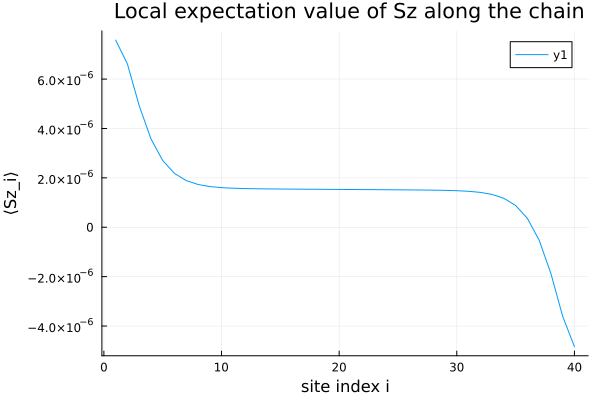

In [107]:
plot(Sz_exp_vals,title=" Local expectation value of Sz along the chain",xlabel="site index i", ylabel="⟨Sz_i⟩")

The result obtained ..... my expactation because

### b.

Calculating the correlations Sz1Szi as a function of i

In [125]:
SzSz_corr_array = [ expactation_O1i_O2j(psi_mps,Sz,1,Sz,i) for i in 2:L];

Plotting as a function of i

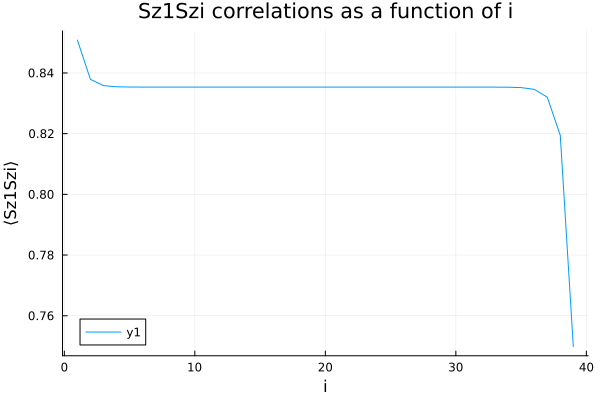

In [126]:
plot(SzSz_corr_array,title="Sz1Szi correlations as a function of i", xlabel="i",ylabel="⟨Sz1Szi⟩")

### c.

In [131]:
contracted_psi=ContractMPS(psi_mps.state)

LoadError: OutOfMemoryError()

In [128]:
CorrelationsByLength(psi_mps, Sz)

LoadError: DimensionMismatch: non-matching sizes in contracted dimensions

## 2.2 Paramagnetic phase

In [30]:
L=40
h=1.5
beta=10
dt=0.1
maxM=20;

In [81]:
psi_mps=find_ground_state_using_iTEBD(L, h , beta, dt, maxM):

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -66.6628475834387
Energy after imaginary time step 20 is -66.69281815155472
Energy after imaginary time step 30 is -66.6929854193107
Energy after imaginary time step 40 is -66.6929931143841
Energy after imaginary time step 50 is -66.6929936928495
Energy after imaginary time step 60 is -66.6929937445695
Energy after imaginary time step 70 is -66.6929937496154
Energy after imaginary time step 80 is -66.6929937501355
Energy after imaginary time step 90 is -66.69299375019136
Energy after imaginary time step 100 is -66.69299375019725


## 2.3 Critical point

In [ ]:
L=40
h=1
beta=100
dt=0.1
maxM=20;

In [87]:
psi_mps=find_ground_state_using_iTEBD(L, h , beta, dt, maxM):

psi_mps.oc = 1
psi_mps.maxM = -1
Energy after imaginary time step 10 is -50.06224548273411
Energy after imaginary time step 20 is -50.502383347076105
Energy after imaginary time step 30 is -50.546942294861516
Energy after imaginary time step 40 is -50.55981584659124
Energy after imaginary time step 50 is -50.564816316039206
Energy after imaginary time step 60 is -50.567074011218835
Energy after imaginary time step 70 is -50.56818219966187
Energy after imaginary time step 80 is -50.568752865630096
Energy after imaginary time step 90 is -50.56905521988574
Energy after imaginary time step 100 is -50.56921835561672
Energy after imaginary time step 110 is -50.569307548433706
Energy after imaginary time step 120 is -50.56935687352975
Energy after imaginary time step 130 is -50.5693844660471
Energy after imaginary time step 140 is -50.56940009869352
Energy after imaginary time step 150 is -50.569409085959386
Energy after imaginary time step 160 is -50.56941434080439
Energy after imaginary tim

# 3. AKLT model

Unused functions

In [58]:
# Based on BondH From Recitation 5
#=
function BondH(h::Float64)
    """
    BondH(h1::Float64, h2::Float64)

    Generate the bond Hamiltonian matrix for a two-site bond in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The Hamiltonian matrix for the two-site bond in the TFIM.

    """
    # Pauli matrices
    Sx = [0.0 1.0; 1.0 0.0]
    Sz = [1.0 0.0; 0.0 -1.0]
    Id = [1.0 0.0; 0.0 1.0]

    # Construct the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = -kron(Sz, Sz) + h*(kron(Sx, Id) + kron(Id, Sx))
    
    return Hb
end;
function ∏ₙᴸIₙ(L)
    if L==0
        return 1
    end
    Id=[1.0 0.0; 0.0 1.0]
    Id_temp= Id
    #Id_arr= [Id]
    for i in 1:L-1
        #push!(Id_arr,last(Id_arr)⊗Id)
        Id_temp = Id_temp⊗Id
    end
    return Id_temp
end;
function O_exp(psi::Vector{Array{Float64}},O_array)
    """
    O_array is a tuple (i,O) - when i is the index of the site and O is the operator to be applied on the site
    """
    
    L = length(psi)
    
    Exp_tot = 0.

    for (i,O) in O_array
        
        # Initialize a tensor for O*psi
        O_psi = zeros(size(psi[i]))
        
        # Contract O with the current site tensor to obtain O * psi
        @tensor O_psi[l0, sp, l2] = O[sp,s] * psi[i][l0,s, l2]
        
        # Contract psi^† * H * psi to obtain the energy contribution
        @tensor psi_O_psi = psi[i][l0, sp, l2] * O_psi[l0, sp, l2]
        
        # Accumulate the energy contribution
        Exp_tot += psi_O_psi
    end
    
    return Etot
end;
function local_O_expectation!(psi_mps,O,i)
    OrthogonalizePsi!(psi_mps, i)
    Ai=psi_mps.state[i]
    M0=size(Ai)[1]
    M1=size(Ai)[3]
    #contract with the ith site tensor
    # Initialize tensors for Ai * O
    Ai_O = zeros(M0, 2, M1)
    @tensor Ai_O[l0, sp, l1] = Ai[l0, s, l1] * O[s, sp]

    # Calculate Ai * O * Ai'
    Ai_O_Aip = zeros(M1, M1)
    @tensor Ai_O_Aip[l1, l1p] = Ai_O[l0, sp, l1] * Ai[l0, sp, l1p]
end;
=#